# Timeseries forecasting #

In [1]:
# Python 
import datetime
import warnings
warnings.filterwarnings(action = 'ignore')
# import os

# Thrid part
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('seaborn') # ggplot
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 20)
# pd.options.display.float_format = '{:,.2f}'.format

# Facebook Prophet
from prophet import Prophet

# Support modules
from support import utils, ml
from support.orders import Orders

In [7]:
# Load data
df, df_models, df_service = utils.load_data()

# For anonymous demo
# df, df_models, df_service = utils.my_randomizer(df, df_models, df_service)

In [8]:
# Make timeseries. 

date_start = datetime.datetime(2017,1,1,0,0,0)
date_end = datetime.datetime(2022,4,30)

kwargs = {
    'event': {
        'date_start': date_start
        , 'date_end': date_end
    },
    'context': {'df': df},
    'kind': 'timeseries'
}

# Note, UT returns a tuple of which [1] is a dataframe
try:
    timeseries = utils.make_pivot(**kwargs)[0]
    if timeseries is not None:
        timeseries = timeseries.loc[:,'Total']
        print('Timeseries (months): ', timeseries.shape[0])
except Exception as e:
    print(e)

Timeseries (months):  64


## Make predictions using FB Prophet ##

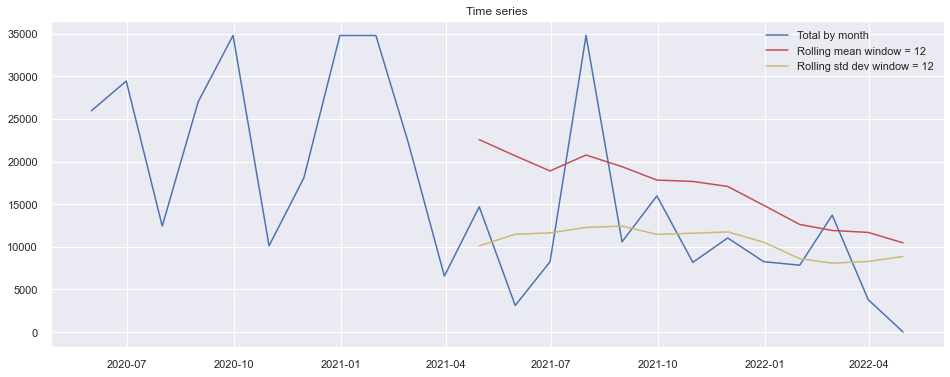

Timeseries

NormaltestResult(statistic=42.88701437819183, pvalue=4.866347914324493e-10)
mean: 19410.3048781263, std: 12364.755084498041
reject null, the series is stationary:  -5.72428890164898 6.827806593583467e-07
Test Statistic         -5.724289e+00
p-value                 6.827807e-07
Lags Used               0.000000e+00
Observations Used       6.300000e+01
Critical Value (1%)    -3.538695e+00
Critical Value (5%)    -2.908645e+00
Critical Value (10%)   -2.591897e+00
dtype: float64
None


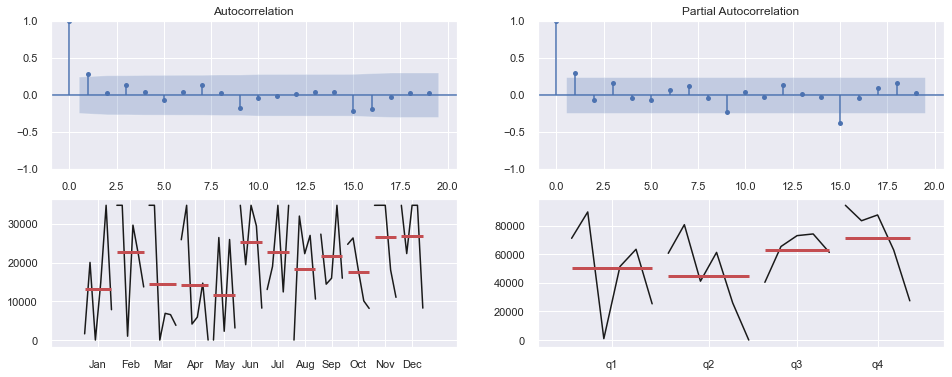

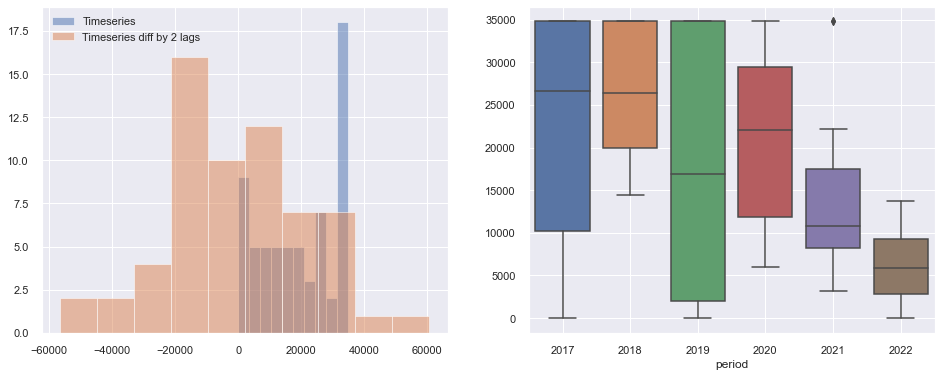

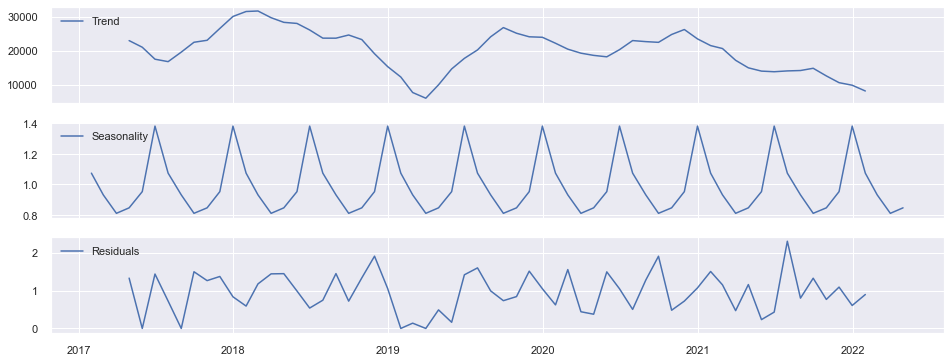

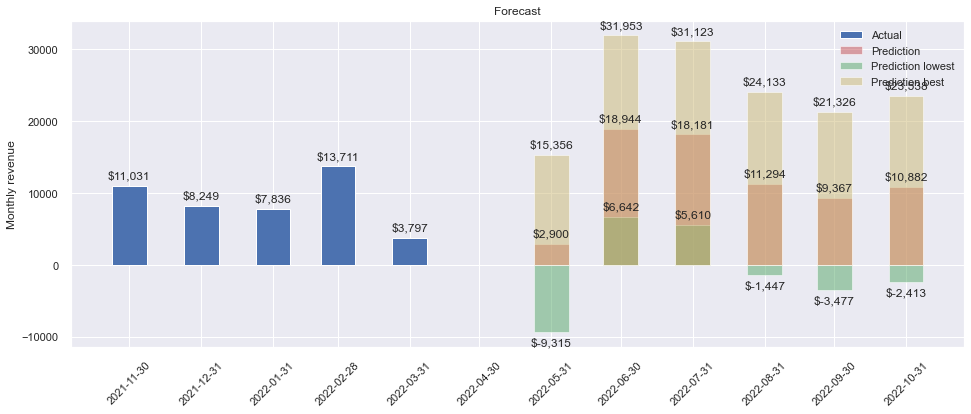

Forecast between 2022-05-31 and 2022-10-31
#########################################################
Normal:  $71,569
Lowest:  $-4,399
Best:  $147,428
#########################################################


In [9]:
# Make predictions

kwargs = {
    'context': {
        'tseries' : timeseries
    },
    'event': {
        'remove_outliers' : True
        , 'window_roll' : 12
        , 'ts_seasonality': 6
        , 'ts_model': 'multiplicative'
        , 'months_to_plot' : 24
        , 'out_of_sample_months' : 6
        , 'figsize' : (16,6)
        , 'barwidth' : 15
        , 'dump_path': None #'reports'
    }
}

mse = ml.make_prediction(**kwargs)

## Experimental part of the notebook using other forecasting models ##

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
warnings.filterwarnings(action='ignore', module='statsmodels')

ts = timeseries[:'2022']
prophet_df = pd.DataFrame({'ds': ts.index.values, 'y': ts.values})
forecast_period = pd.date_range('2021-10-01','2021-12-31', freq='M')

ts = ts.values #+ 1e-12 # > 0 for the smoothing optimization

ts_train, ts_test = tts(ts, test_size=0.3)

trends = ["add", "mul"]
seasonals = ["add", "mul"]
seasonal_periods = [6,12]
initialization_methods = ["estimated", "heuristic"] 
use_boxcox = [True, False]
missing = ['none', 'drop']

metric_expsm = 1e12
params_expsm = []

for m in initialization_methods:
    for b in use_boxcox:
        for t in trends:
            for s in seasonals:
                for p in seasonal_periods:
                    for n in missing:
                        try:
                            kwargs = {
                                    'endog': ts_train,
                                    'initialization_method': m,
                                    'use_boxcox': b,
                                    'trend': t,
                                    'seasonal': s,
                                    'seasonal_periods': p,
                                    'missing': n
                            }
                            triple = ExponentialSmoothing(**kwargs).fit(optimized=True)
                            metric = mse(ts_test, triple.forecast(len(ts_test)))
                            if metric < metric_expsm:
                                metric_expsm = metric
                            params_expsm = [m,b,t,s,p,n]
                        except Exception as e:
                            # print(e, params_expsm)
                            continue

seasonals = ["additive", "multiplicative"]

metric_proph = 1e12
param__proph = None

for s in seasonals:
    try:
        m = Prophet(seasonality_mode=s,
                   weekly_seasonality=False,
                   daily_seasonality=False)
        m.fit(prophet_df)
        prohpet_preds = m.predict(
            m.make_future_dataframe(periods=len(ts_test),
                                    freq='M',
                                    include_history = False)
            )
        metric = mse(ts_test, prohpet_preds.yhat)  #  - 1e-12
        if metric < metric_proph:
            metric_proph = metric
            param__proph = s
    except Exception as e:
        print(e, param__proph)
        continue

orders_p = [0,1,2]
orders_d = [0,1]
orders_q = [0,1,2]
seasonal_orders_p = [0,1]
seasonal_orders_d = [0,1]
seasonal_orders_q = [0,1]
seasonal_orders = [6,12]
trends = ['n', 'c', 't', 'ct']

metric_sarima = 1e12
param__sarima = None
for p in orders_p:
    for d in orders_d:
        for q in orders_q:
            for sp in seasonal_orders_p:
                for sd in seasonal_orders_d:
                    for sq in seasonal_orders_q:
                        for s in seasonal_orders:
                            for t in trends:
                                try:
                                    sar = SARIMAX(ts_train, 
                                        order=(p,d,q), 
                                        seasonal_order=(sp,sd,q,s), 
                                        trend=t).fit()
                                    sar_predict = pd.Series(sar.predict(start = len(ts_train) + 1, end= len(ts)))
                                    metric = mse(ts_test, sar_predict) #  - 1e-12
                                    if metric < metric_sarima:
                                        metric_sarima = metric
                                        param__sarima = [p,d,q,sp,sd,sq,s,t] 
                                except Exception as e:
                                    print(e, param__sarima)
                                    continue

print(
    f'\nTriple: {np.sqrt(metric_expsm):,.2f}, {params_expsm}',
    f'\nProphet: {np.sqrt(metric_proph):,.2f}, {param__proph}',
    f'\nSarima: {np.sqrt(metric_sarima):,.2f}, {param__sarima}'
    )

kwargs = {
        'endog': ts,
        'initialization_method': params_expsm[0],
        'use_boxcox': params_expsm[1],
        'trend': params_expsm[2],
        'seasonal': params_expsm[3],
        'seasonal_periods': params_expsm[4],
        'missing': params_expsm[5]
}
triple = ExponentialSmoothing(**kwargs).fit(optimized=True)
triple_preds = pd.Series(triple.forecast(len(forecast_period)))

m = Prophet(seasonality_mode=param__proph,
                weekly_seasonality=False,
                daily_seasonality=False)
m.fit(prophet_df)
prohpet_preds = m.predict(
    m.make_future_dataframe(periods=len(forecast_period),
                            freq='M',
                            include_history = False)
    )

kwargs = {
        'endog': ts,
        'order': (param__sarima[0],
                  param__sarima[1],
                  param__sarima[2]),
        'seasonal_order': (param__sarima[3],
                           param__sarima[4],
                           param__sarima[5],
                           param__sarima[6]),
        'trend': param__sarima[7]
}
sar = SARIMAX(**kwargs).fit()
sar_predict = pd.Series(sar.predict(start = 1, end = len(forecast_period)))

forecasts = pd.concat([pd.Series(ts[-len(forecast_period):]),
                        triple_preds,
                        prohpet_preds.yhat,
                        sar_predict]
                        , axis=1)\
    .set_index(forecast_period)
forecasts.columns = ['actual','triple_smooth', 'prophet', 'sarima']  

plt.figure(figsize=(10,6), dpi=100)
plt.plot(timeseries['2021'], label='actual')
plt.plot(forecasts[['triple_smooth', 'prophet', 'sarima']], label=['triple exp smoothing', 'prophet', 'sarima'])
plt.legend()
plt.show()

display(forecasts)

print(
    f'\nActual last Q: {np.sum(ts[-len(forecast_period):]):,.2f}', 
    f'\nTriple: {np.sum(forecasts.triple_smooth):,.2f}',
    f'\nProphet: {np.sum(forecasts.prophet):,.2f}',
    f'\nSarima: {np.sum(sar_predict):,.2f}'
    )